In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy 


#WARNING: Need version 1.0 (RC)
import metpy.calc as mpcalc
from metpy.plots import SkewT

from metpy.units import units

from pyproj import CRS, Transformer, __version__, __proj_version__

In [2]:
maskfile=xr.open_mfdataset('/users/davidle/postproc_data/lm_c_PRUDENCE_MASKS_LAND.nc')

path = '/scratch/snx3000/davidle/results_soil-moisture-pertubation/dry25_lm_f/2006/lm_c/1h/'
filename = 'lffd20060?????c.nc'

const = xr.open_mfdataset(path+filename, parallel=True)

In [136]:
path = '/scratch/snx3000/davidle/results_soil-moisture-pertubation/wet25_lm_f_domain/2006/lm_c/1h/'
filename = 'lffd20060?????.nc'

files = xr.open_mfdataset(path+filename, parallel=True)
#wet=files.sel(time="2006-07-12")
wet = xr.concat([files.sel(time=slice("2006-07-02", "2006-07-04")), files.sel(time=slice("2006-07-11", "2006-07-26"))], dim='time')
wet = wet.sortby('level', ascending=False) #reverse leves because metpy excepts highest pressure first

#wet = xr.concat([files.sel(time=slice("2006-07-02", "2006-07-04")), files.sel(time=slice("2006-07-11", "2006-07-26"))], dim='time')
wet = wet.chunk(chunks={"time": 1, 'level': wet.level.size,  "rlat":np.ceil(wet.rlat.size / 10), "rlon": np.ceil(wet.rlon.size / 10)}) #Faster than passing to open_mfdataset

In [137]:
path = '/scratch/snx3000/davidle/results_soil-moisture-pertubation/dry25_lm_f_domain/2006/lm_c/1h/'
filename = 'lffd20060?????.nc'

files = xr.open_mfdataset(path+filename, parallel=True)
#dry=files.sel(time="2006-07-12")
dry = xr.concat([files.sel(time=slice("2006-07-02", "2006-07-04")), files.sel(time=slice("2006-07-11", "2006-07-26"))], dim='time')
dry = dry.sortby('level', ascending=False) #reverse leves because metpy excepts highest pressure first

#dry = xr.concat([files.sel(time=slice("2006-07-02", "2006-07-04")), files.sel(time=slice("2006-07-11", "2006-07-26"))], dim='time')
dry = dry.chunk(chunks={"time": 1, 'level': dry.level.size,  "rlat":np.ceil(dry.rlat.size / 10), "rlon": np.ceil(dry.rlon.size / 10)}) #Faster than passing to open_mfdataset

# SkewT-LogP profiles and Cape

In [166]:
def draw_skewT(d, fig, color):
   
    #compute dewpoint
    T = units.degC * (d.T.values - 273.15)
    P = units.hPa * (d.P.values / 100)
    QV = d.QV.values
    Td = mpcalc.dewpoint_from_specific_humidity(P, T, QV) 

    fig.plot(P, T, color=color, linewidth=4)
    fig.plot(P, Td, color=color, linewidth=4, linestyle='dashed')
      
    # Shade areas of CAPE and CIN
    lvl=3 #50 hPa
    prof = mpcalc.parcel_profile(P[lvl:], T[lvl], Td[lvl])
    fig.plot(P[lvl:], prof, 'k', linewidth=2)
    fig.shade_cin(P[lvl:], T[lvl:], prof, dewpoint=Td[lvl:])
    fig.shade_cape(P[lvl:], T[lvl:], prof)
    
    # Add the relevant special lines
    fig.plot_dry_adiabats(color='C7')
    fig.plot_moist_adiabats(color='C7')
    fig.plot_mixing_lines(color='C7')

In [265]:
def plot_skewT_point(dry, wet):
    fig = plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 18})
    
    skew = SkewT(fig, rotation=45)
    skew.ax.set_xlim(-13, 36)
    skew.ax.set_ylim(1000, 100)

    plt.xlabel('Temperature [deg]')
    plt.ylabel('Pressure [hPa]')
    
    draw_skewT(dry, skew, 'C3')
    draw_skewT(wet, skew, 'C0')
    

In [266]:
# Define naive_fast that searches for the nearest model grid cell center
def naive_fast(latvar,lonvar,lat0,lon0):
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:]
    lonvals = lonvar[:]
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()  # 1D index of min element
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return iy_min,ix_min


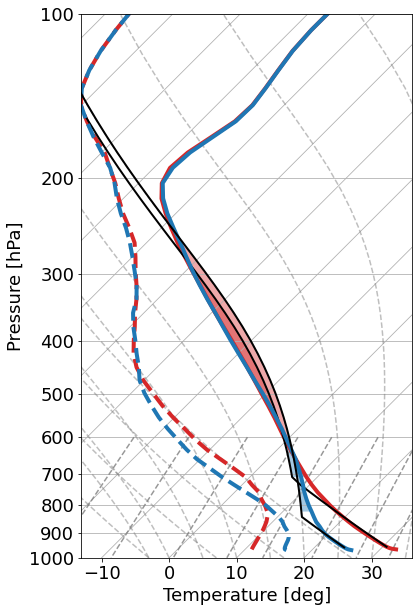

In [267]:
#Payerne
lat=46.811581
lon=6.942469 
t = 12

#obtain indices
(c_y, c_x) = naive_fast(const.lat.values, const.lon.values, lat, lon)

plot_skewT_point(dry.isel(rlon=c_x, rlat=c_y).groupby('time.hour').mean().isel(hour=t), wet.isel(rlon=c_x, rlat=c_y).groupby('time.hour').mean().isel(hour=t))
plt.savefig('lm_c_skewt_Payerne.pdf', bbox_inches='tight')

In [ ]:
def metpy_surface_based_cape_cin(f):
    CAPE_t = np.zeros(f.time.size)
    CIN_t = np.zeros(f.time.size)
    
    for t in range(f.time.size):
        T = units.degC * (f.T.isel(time=t).values - 273.15)
        P = units.hPa * (f.isel(time=t).P.values / 100)
        QV = f.isel(time=t).QV.values
    
        Td = mpcalc.dewpoint_from_specific_humidity(P, T, QV)
        res = mpcalc.surface_based_cape_cin(P, T, Td)
        CAPE_t[t] = res[0].magnitude
        CIN_t[t] = res[1].magnitude

    #Diurnal Cylce
    CAPE = np.zeros(24)
    CIN = np.zeros(24)
    
    for t in range(24):
        CAPE[t] = np.mean(CAPE_t[t::24])
        CIN[t] = np.mean(CIN_t[t::24])
        
    CAPE = np.hstack((CAPE,CAPE[0]))
    CIN = np.hstack((CIN, CIN[0]))

    return CAPE, np.abs(CIN)

In [211]:
#Payerne
lat=46.811581
lon=6.942469 
t = 12

(c_y, c_x) = naive_fast(const.lat.values, const.lon.values, lat, lon)
(dry_CAPE, dry_CIN) = metpy_surface_based_cape_cin(dry.isel(rlon=c_x, rlat=c_y, level=slice(3, None)))
(wet_CAPE, wet_CIN) = metpy_surface_based_cape_cin(wet.isel(rlon=c_x, rlat=c_y, level=slice(3, None)))

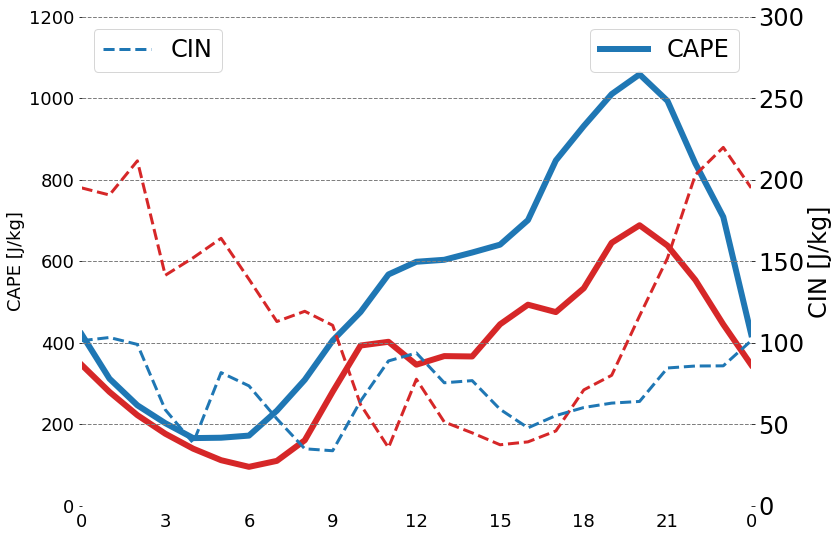

In [268]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

plt.rcParams.update({'font.size': 24})
plt.xlim(0,24)
ax.set_ylim(0,1200)
ax.set_ylabel('CAPE [J/kg]')
plt.grid(True, color='C7', linestyle='--', linewidth=1, axis='y',zorder=0)

plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24], ['0', '3', '6', '9', '12', '15', '18', '21', '0'])

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
ax.tick_params(axis="both", which="both", bottom=False, top=False,
              labelbottom=True, left=False, right=False, labelleft=True)

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.plot(np.arange(25), dry_CAPE,  color='C3', linewidth=6, zorder=1)
ax.plot(np.arange(25), wet_CAPE,  color='C0', linewidth=6, zorder=1, label='CAPE')
plt.legend(loc='upper right')


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(np.arange(25), dry_CIN,  color='C3', linewidth=3, linestyle='dashed', zorder=2)
ax2.plot(np.arange(25), wet_CIN,  color='C0', linewidth=3, linestyle='dashed', zorder=2, label='CIN')
ax2.set_ylim(0,300)
ax2.set_ylabel('CIN [J/kg]')


# Remove the plot frame lines. They are unnecessary chartjunk.  
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)  
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)

plt.legend(loc='upper left')

plt.savefig('lm_c_dcyle_CAPE_CIN_Payerne.pdf', bbox_inches='tight')